#### Zero-shot Evaluation

The three models—**CLIP**, **BLIP**, and **ViLT**—were evaluated using two sets of prompts (Minimal input prompts and Contextualized prompts), each following a similar structural pattern:

- **Prompt 1**: Contained only the question.  
- **Prompt 2**: Included the question along with a list of all possible answers.  
- **Prompts 3, 4 (and 5)**: Extended Prompt 2 by adding contextual information alongside the question and answer choices.

The notebook has the following visualisations:

- Accuracy per Prompt (Grouped by Model)
- F1 Score per Prompt (Grouped by Model)
- Barplot: Accuracy per Question by Model+Prompt
- Heatmap of Accuracy (Model+Prompt vs. Question)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix

In [7]:
def compute_metrics(df_true, df_pred):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, log_loss
    )

    metrics = {
        'Accuracy': [], 'Precision': [], 'Recall': [],
        'F1 Score': []
    }

    for column in df_true.columns:
        y_true = df_true[column].astype(str).str.strip().str.lower()
        y_pred = df_pred[column].astype(str).str.strip().str.lower()

        # Combine to avoid unseen label error
        combined_labels = pd.concat([y_true, y_pred])
        le = LabelEncoder().fit(combined_labels)

        y_true_enc = le.transform(y_true)
        y_pred_enc = le.transform(y_pred)

        # One-hot encode
        y_true_onehot = pd.get_dummies(y_true_enc)
        y_pred_onehot = pd.get_dummies(y_pred_enc)

        # Align columns (same class order)
        y_true_onehot, y_pred_onehot = y_true_onehot.align(y_pred_onehot, fill_value=0, axis=1)

        # Core metrics
        metrics['Accuracy'].append(accuracy_score(y_true_enc, y_pred_enc))
        metrics['Precision'].append(precision_score(y_true_enc, y_pred_enc, average='weighted', zero_division=0))
        metrics['Recall'].append(recall_score(y_true_enc, y_pred_enc, average='weighted', zero_division=0))
        metrics['F1 Score'].append(f1_score(y_true_enc, y_pred_enc, average='weighted', zero_division=0))


    return pd.DataFrame(metrics, index=df_true.columns)

def plot_metrics(metrics_df, title="Evaluation Metrics per Question"):
    metrics_df.plot(kind='bar', figsize=(14, 8))
    plt.title(title)
    plt.xlabel('Question')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(plt)


##### Zero Shot Models - CLIP, VILT, and BLIP

In [8]:
import pandas as pd
import numpy as np

# Define question columns
question_cols = [
    "What limb is injured?",
    "Is the patient intubated?",
    "Where is the catheter inserted?",
    "Is there bleeding?",
    "Has the bleeding stopped?",
    "Is the patient moving?",
    "Is the patient breathing?",
    "Is there a tourniquet?",
    "Is there a chest tube?",
    "Are the patient and instruments secured?",
    "If a limb is missing which one?",
    "Is there mechanical ventilation?",
    "What is the position of the injury?"
]

CLASSES = [
    ['no limb is injured', 'left leg', 'left arm', 'right leg', 'right arm'],
    ["can't identify", 'no', 'yes'],
    ['no catheter is used', 'lower limb'],
    ['no', 'yes'],
    ['there is no bleeding', 'no', 'yes'],
    ["can't identify", 'yes', 'no'],
    ["can't identify", 'no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes', "can't identify"],
    ['none', 'left arm', 'left leg', 'right leg'],
    ["can't identify", 'no', 'yes'],
    ['thorax', 'throat', "can't identify", 'lower limb', 'abdomen', 'upper limb']
]


In [9]:
def prepare_all_model_prompts(all_preds: dict, df_true, question_cols):
    """
    Takes in model predictions and splits them by prompt.
    Returns: model_prompt_preds dict and shared aligned ground truth.
    """
    def parse_image_id(image_name):
        vid, frame = image_name.replace(".jpg", "").split("_frame")
        return pd.Series([vid, int(frame)])

    model_prompt_preds = {}
    shared_df_true = None

    for model_name, pred_df in all_preds.items():
        pred_df[["video_id", "frame"]] = pred_df["Image"].apply(parse_image_id)

        for prompt in pred_df["Prompt"].unique():
            key = f"{model_name}_{prompt}"
            df_prompt = pred_df[pred_df["Prompt"] == prompt].copy()

            merged = df_true.merge(df_prompt, on=["video_id", "frame"], suffixes=("_true", "_pred"))
            df_true_aligned = merged[[q + "_true" for q in question_cols]].copy()
            df_pred_aligned = merged[[q + "_pred" for q in question_cols]].copy()

            df_true_aligned.columns = question_cols
            df_pred_aligned.columns = question_cols

            model_prompt_preds[key] = df_pred_aligned

            # Use any one as shared truth (they're the same for all prompts)
            if shared_df_true is None:
                shared_df_true = df_true_aligned

    return shared_df_true, model_prompt_preds


In [10]:

def evaluate_all_models(model_preds: dict, df_true: pd.DataFrame, questions: list[str], classes: list[list[str]],
                        show_reports=True, show_confusion=False):
    """
    Evaluate predictions for multiple models against the ground truth using detailed metrics.

    Returns:
        dict of DataFrames: metrics summary for each model
    """
    df_true_clean = df_true[questions].copy().apply(lambda col: col.astype(str).str.strip().str.lower())
    model_metrics = {}

    for model_name, df_pred in model_preds.items():
        print(f"\n=== Evaluating Model: {model_name.upper()} ===")
        df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())

        # Use custom metric computation
        metrics_df = compute_metrics(df_true_clean, df_pred_clean)
        model_metrics[model_name] = metrics_df

        # Optional: classification reports and confusion matrices
        for i, q in enumerate(questions):
            y_true = df_true_clean[q]
            y_pred = df_pred_clean[q]

            if show_reports:
                print(f"\n--- {q} ---")
                print(classification_report(y_true, y_pred, labels=classes[i], zero_division=0))

            if show_confusion:
                cm = confusion_matrix(y_true, y_pred, labels=classes[i])
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes[i], yticklabels=classes[i], cmap='Blues')
                plt.title(f"Confusion Matrix: {model_name.upper()} - {q}")
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

    return model_metrics


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_metric_heatmaps(all_prompt_preds, df_true_aligned, metric_name="Accuracy"):
    """
    Plot heatmaps of a selected metric (e.g., Accuracy) per prompt for each model.

    Parameters:
    - all_prompt_preds: dict with keys like 'clip_prompt1', 'blip_prompt2', etc.
    - df_true_aligned: ground truth DataFrame aligned with predictions
    - metric_name: string name of the metric to plot (e.g., "Accuracy", "F1 Score")
    """
    models = ["clip", "vilt", "blip"]
    fig, axes = plt.subplots(1, len(models), figsize=(20, 6), sharey=True)

    for idx, model in enumerate(models):
        model_metric_df = pd.DataFrame()

        for i in range(1, 6):  # Prompt 1 to 5
            key = f"{model}_prompt{i}"

            if key not in all_prompt_preds:
                print(f"{key} not found in predictions — skipping.")
                continue

            df_pred = all_prompt_preds[key]
            metrics_df = compute_metrics(df_true_aligned, df_pred)

            # Check if metric exists
            if metric_name not in metrics_df.columns:
                raise ValueError(f"Metric '{metric_name}' not found in computed metrics.")

            model_metric_df[f"Prompt {i}"] = metrics_df[metric_name]

        # Plot heatmap
        sns.heatmap(
            model_metric_df,
            ax=axes[idx],
            annot=True,
            cmap="YlGnBu",
            fmt=".2f",
            linewidths=0.5,
            cbar=(idx == len(models) - 1),
            cbar_kws={'label': metric_name}
        )

        axes[idx].set_title(f"{model.upper()} — {metric_name} per Prompt")
        axes[idx].set_xlabel("Prompts")
        if idx == 0:
            axes[idx].set_ylabel("Question")

    plt.tight_layout()
    plt.show()


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracy_barplot(all_metrics_df):
    """
    Plots a grouped barplot of Accuracy per Question across all Model+Prompt combinations.
    """

    # Convert dict to long-form DataFrame
    records = []
    for key, df in all_metrics_df.items():
        for question, row in df.iterrows():
            records.append({
                "Model+Prompt": key,
                "Question": question,
                "Accuracy": row["Accuracy"]
            })
    all_metrics_long_df = pd.DataFrame.from_records(records)

    # Assign color palettes to each prompt within a model
    keys = all_metrics_long_df["Model+Prompt"].unique()
    palette = {}
    for key in keys:
        prompt_index = int(key.split("prompt")[-1]) - 1
        if "clip" in key:
            palette[key] = sns.color_palette("rocket", 5)[prompt_index]
        elif "blip" in key:
            palette[key] = sns.color_palette("Greens", 5)[prompt_index]
        elif "vilt" in key:
            palette[key] = sns.color_palette("mako", 5)[prompt_index]

    # Plot
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(
        data=all_metrics_long_df,
        x="Question",
        y="Accuracy",
        hue="Model+Prompt",
        palette=palette
    )

    # Optional: add text labels for prompt number
    for bar, label in zip(ax.patches, all_metrics_long_df["Model+Prompt"]):
        prompt_num = label.split("prompt")[-1]
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{prompt_num}",
            ha='center',
            va='bottom',
            fontsize=8,
            color='black'
        )

    plt.xticks(rotation=45, ha='right')
    plt.title("Accuracy per Question by Model and Prompt")
    plt.ylabel("Accuracy")
    plt.xlabel("Question")
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Model + Prompt")
    plt.tight_layout()
    plt.show()


In [60]:
def plot_accuracy_heatmap(all_metrics_df):
    """
    Plots a heatmap of Accuracy values with Model+Prompt as rows and Questions as columns.
    """

    # Convert dict to long-form DataFrame
    records = []
    for model_prompt, df in all_metrics_df.items():
        for question, row in df.iterrows():
            records.append({
                "Model+Prompt": model_prompt,
                "Question": question,
                "Accuracy": row["Accuracy"]
            })
    all_metrics_long_df = pd.DataFrame(records)

    # Pivot for heatmap
    pivot_df = all_metrics_long_df.pivot(index="Model+Prompt", columns="Question", values="Accuracy")

    # Plot heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Accuracy'}
    )

    plt.title("Accuracy Heatmap per Question and Prompt", fontsize=14)
    plt.ylabel("Model + Prompt", fontsize=12)
    plt.xlabel("Question", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


**Set 1: Minimal input prompts**

- **Prompt 1**:  
  `[Question]`

- **Prompt 2**:  
  `[Question]? Choose from: [Answers]. Respond with one or 'NA: Cannot be determined'.`  

- **Prompt 3**:  
  `The image shows a medical simulation. [Question]? Options: [Answers]. Choose one or 'NA: Cannot be determined'.`  

- **Prompt 4**:  
  `Analyze this clinical simulation image. [Question]? Select from: [Answers]. or say 'NA: Cannot be determined'.`  

- **Prompt 5**:  
  `[Question]? From the egocentric medical view, answer: [Answers]. or say 'NA: Cannot be determined'.`  



In [61]:
# Assume these are your raw prediction DataFrames
vilt_1 = pd.read_csv("outputs_prompt_set1/vilt_all_prompts_results.csv")
clip_1 = pd.read_csv("outputs_prompt_set1/clip_all_prompts_results.csv")
blip_1 = pd.read_csv("outputs_prompt_set1/blip_all_prompts_results.csv")

df_true = pd.read_csv("analysis/data/combined-df.csv")

all_model_preds = {
    "clip": clip_1,
    "vilt": vilt_1,
    "blip": blip_1
}


In [63]:

# Step 1: Prepare all predictions across models & prompts
df_true_aligned, all_prompt_preds = prepare_all_model_prompts(all_model_preds, df_true, question_cols)
all_metrics_df = evaluate_all_models(
    all_prompt_preds,  # from prepare_all_model_prompts()
    df_true=df_true_aligned,
    questions=question_cols,
    classes=CLASSES,  # List of valid class labels per question
    show_reports=False,
    show_confusion=False
)


=== Evaluating Model: CLIP_PROMPT1 ===

=== Evaluating Model: CLIP_PROMPT2 ===

=== Evaluating Model: CLIP_PROMPT3 ===

=== Evaluating Model: CLIP_PROMPT4 ===

=== Evaluating Model: CLIP_PROMPT5 ===


/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().l


=== Evaluating Model: VILT_PROMPT1 ===

=== Evaluating Model: VILT_PROMPT2 ===

=== Evaluating Model: VILT_PROMPT3 ===

=== Evaluating Model: VILT_PROMPT4 ===

=== Evaluating Model: VILT_PROMPT5 ===


/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().l


=== Evaluating Model: BLIP_PROMPT1 ===

=== Evaluating Model: BLIP_PROMPT2 ===

=== Evaluating Model: BLIP_PROMPT3 ===

=== Evaluating Model: BLIP_PROMPT4 ===

=== Evaluating Model: BLIP_PROMPT5 ===


/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().l

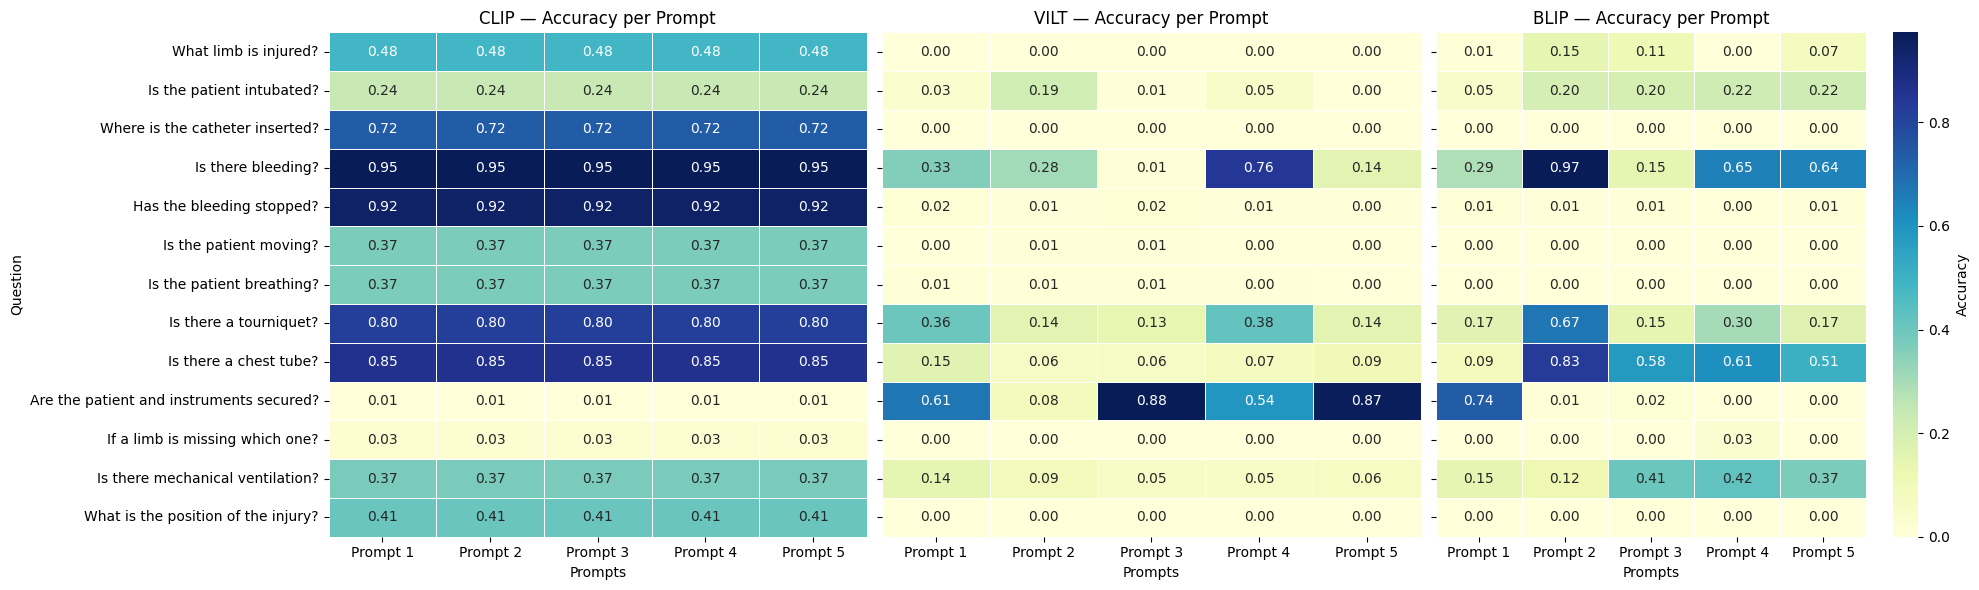

In [64]:
plot_metric_heatmaps(all_prompt_preds, df_true_aligned, metric_name="Accuracy")

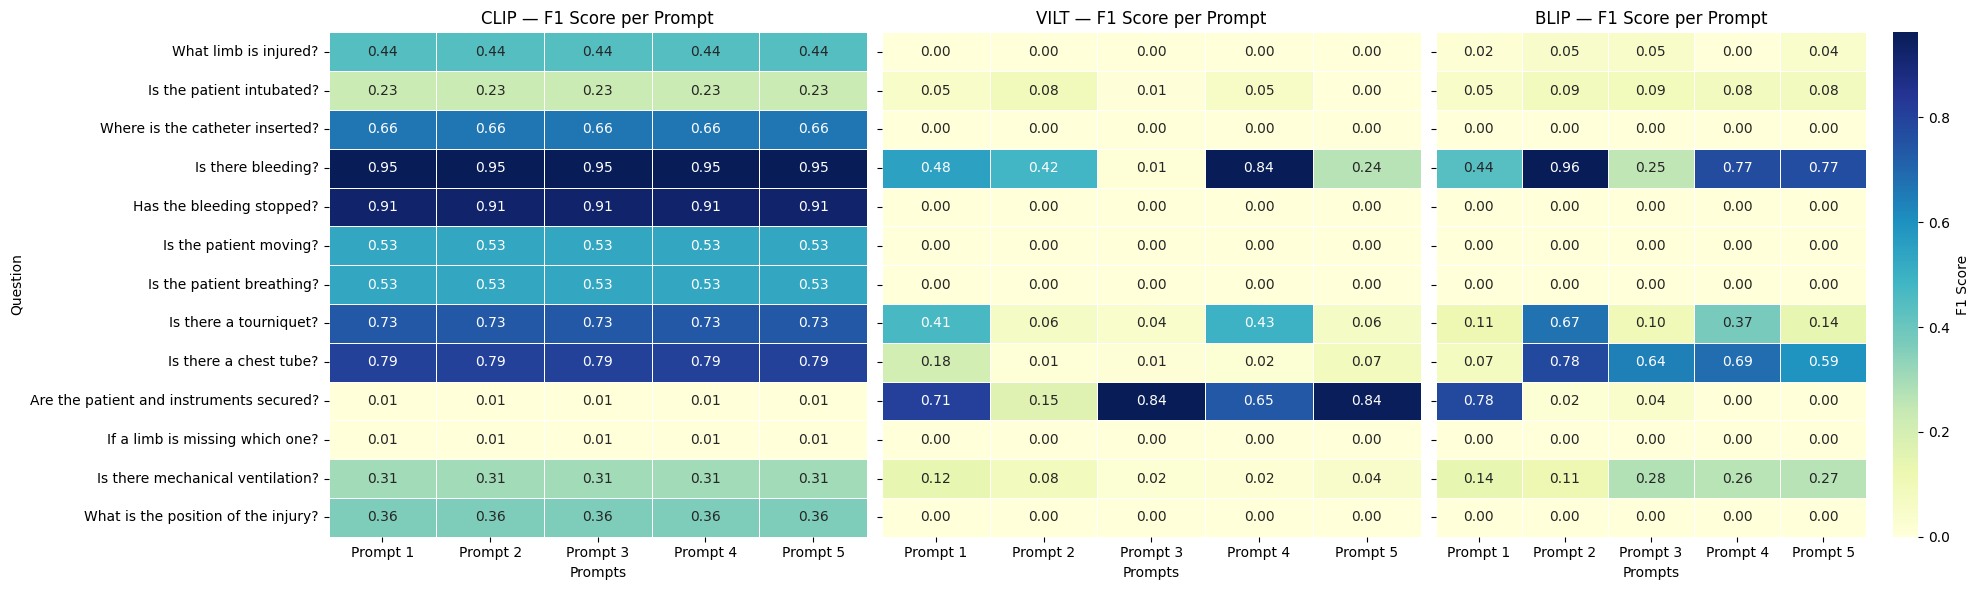

In [65]:
plot_metric_heatmaps(all_prompt_preds, df_true_aligned, metric_name="F1 Score")

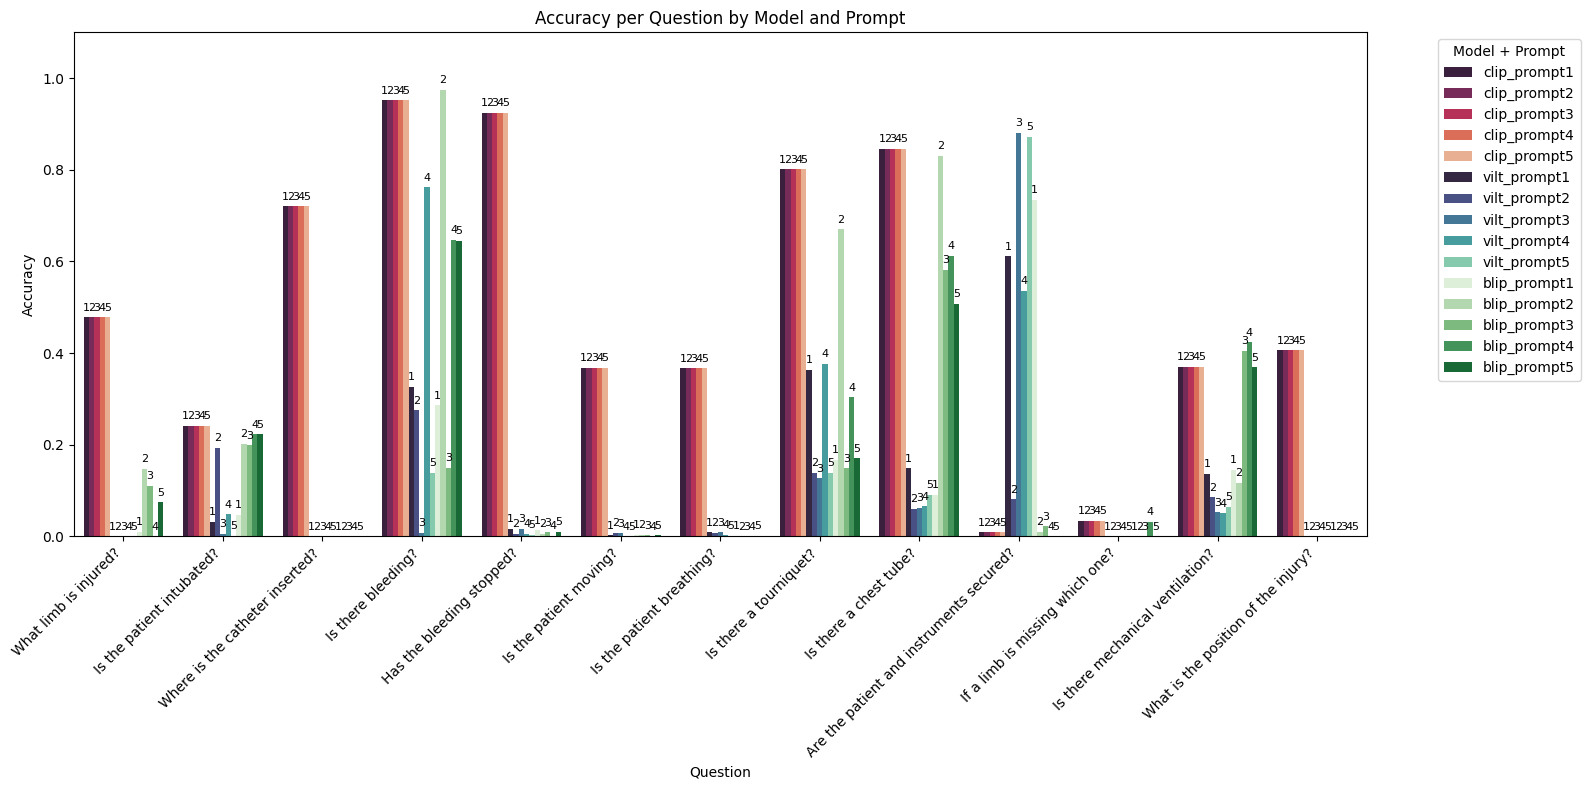

In [66]:
plot_accuracy_barplot(all_metrics_df)

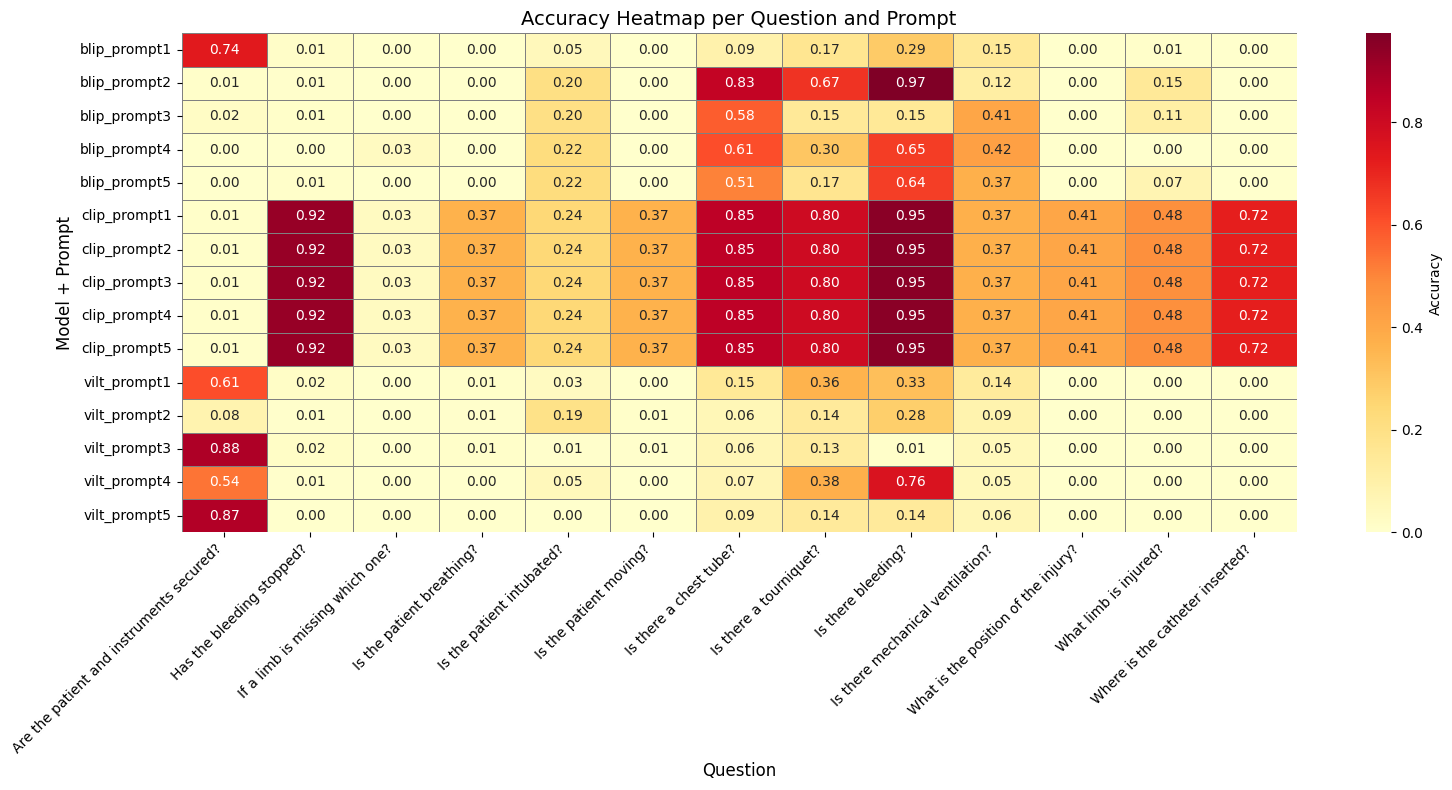

In [67]:
plot_accuracy_heatmap(all_metrics_df)

**Set 2: Contextualized prompts**

- **Prompt 1**:  
  `Carefully examine the image and answer this medical question based solely on what is visually observable. Respond with the most likely answer based on the scene: [Question]`  

- **Prompt 2**:  
  `Observe the image and answer the medical question: [Question]. Choose *only one* answer from these options: [Answers]. If no answer is visually inferable, reply 'NA: Cannot be determined'.`  

- **Prompt 3**:  
  `You are analyzing an emergency trauma scene image captured from a video recorded in a high-stress environment (e.g., mannequin simulation, white sheet background, first responder POV). Given this visual context, answer the question: [Question]. Choose *only one* answer from the options below: [Answers]. If the image lacks sufficient evidence to determine an answer, say 'NA: Cannot be determined'.`  

- **Prompt 4**:  
  `You are a medical AI assistant helping triage trauma patients using scene images from training simulations. These images show patients with or without injuries in settings with mannequins, white sheets, and trauma instruments. Analyze the given image and answer this question based solely on what is visible: [Question]. Select one answer from the following: [Answers]. Answer with *exactly* one choice. If it’s not possible to determine the correct option from the image alone, say: 'NA: Cannot be determined'.`


In [69]:
# Assume these are your raw prediction DataFrames
vilt_2 = pd.read_csv("outputs_prompts_set2/vilt_all_prompts_results.csv")
clip_2 = pd.read_csv("outputs_prompts_set2/clip_all_prompts_results.csv")
blip_2 = pd.read_csv("outputs_prompts_set2/blip_all_prompts_results.csv")

df_true = pd.read_csv("analysis/data/combined-df.csv")

all_model_preds = {
    "clip": clip_2,
    "vilt": vilt_2,
    "blip": blip_2
}

In [70]:

# Step 1: Prepare all predictions across models & prompts
df_true_aligned, all_prompt_preds = prepare_all_model_prompts(all_model_preds, df_true, question_cols)
all_metrics_df = evaluate_all_models(
    all_prompt_preds,  # from prepare_all_model_prompts()
    df_true=df_true_aligned,
    questions=question_cols,
    classes=CLASSES,  # List of valid class labels per question
    show_reports=False,
    show_confusion=False
)


=== Evaluating Model: CLIP_PROMPT1 ===

=== Evaluating Model: CLIP_PROMPT2 ===

=== Evaluating Model: CLIP_PROMPT3 ===

=== Evaluating Model: CLIP_PROMPT4 ===

=== Evaluating Model: VILT_PROMPT1 ===

=== Evaluating Model: VILT_PROMPT2 ===

=== Evaluating Model: VILT_PROMPT3 ===


/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().l


=== Evaluating Model: VILT_PROMPT4 ===

=== Evaluating Model: BLIP_PROMPT1 ===

=== Evaluating Model: BLIP_PROMPT2 ===

=== Evaluating Model: BLIP_PROMPT3 ===

=== Evaluating Model: BLIP_PROMPT4 ===


/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().lower())
/var/folders/0g/5jl4b1d12lvc6g70prn2_rnr0000gn/T/ipykernel_35198/3715279480.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pred_clean = df_pred[questions].copy().applymap(lambda x: str(x).strip().l

clip_prompt5 not found in predictions — skipping.
vilt_prompt5 not found in predictions — skipping.
blip_prompt5 not found in predictions — skipping.


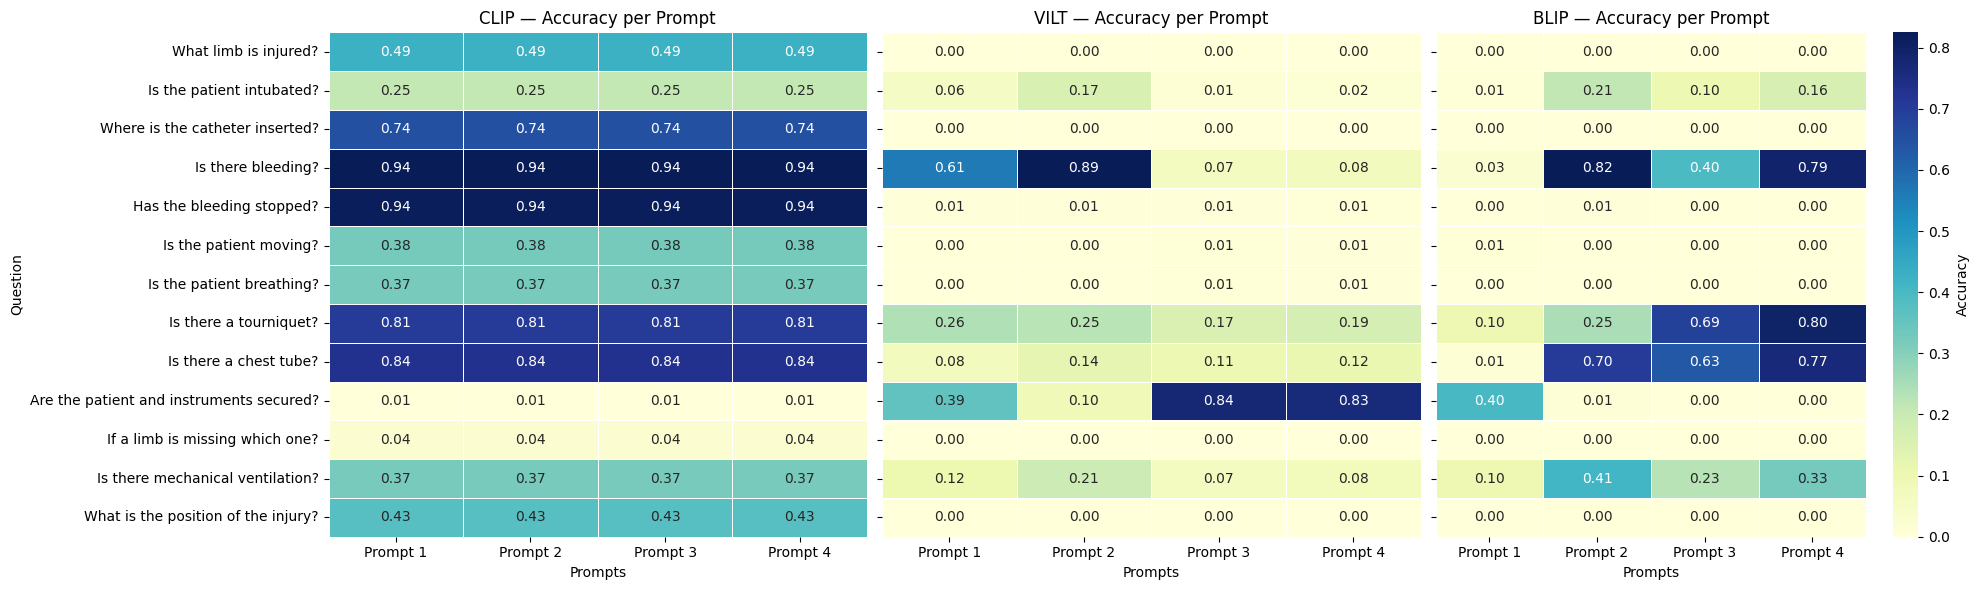

In [71]:
plot_metric_heatmaps(all_prompt_preds, df_true_aligned, metric_name="Accuracy")

clip_prompt5 not found in predictions — skipping.
vilt_prompt5 not found in predictions — skipping.
blip_prompt5 not found in predictions — skipping.


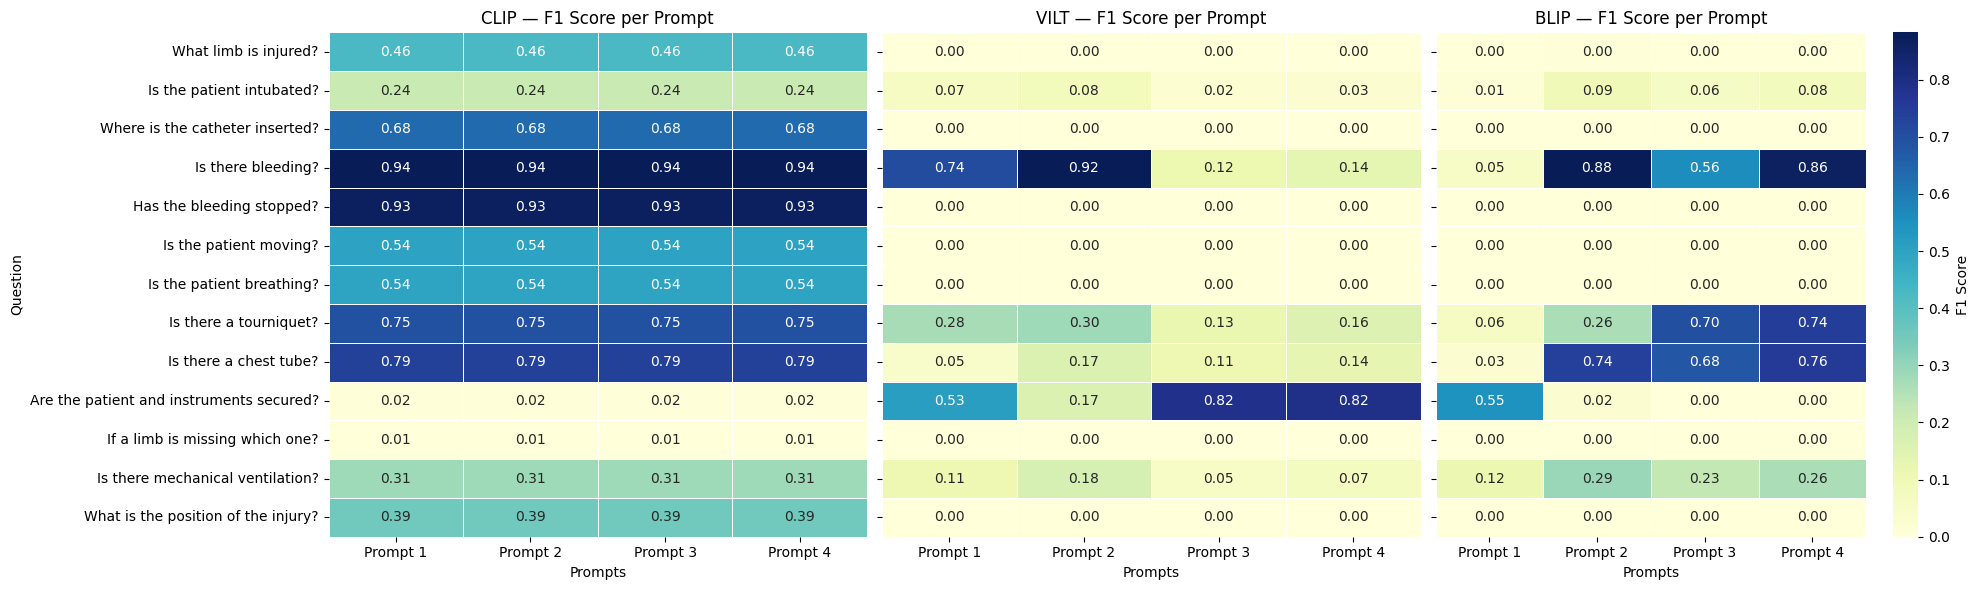

In [72]:
plot_metric_heatmaps(all_prompt_preds, df_true_aligned, metric_name="F1 Score")

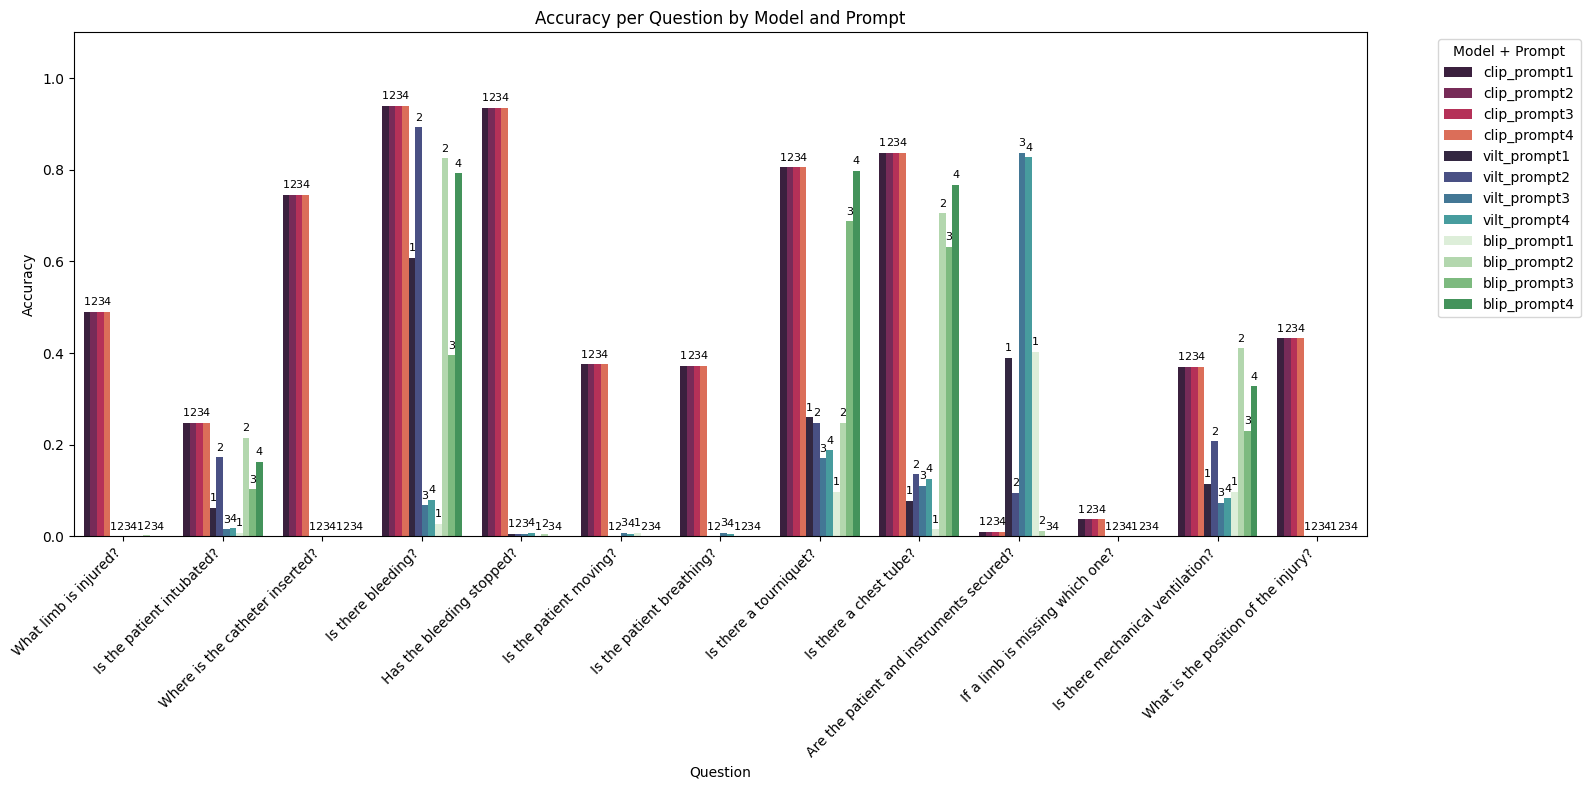

In [73]:
plot_accuracy_barplot(all_metrics_df)

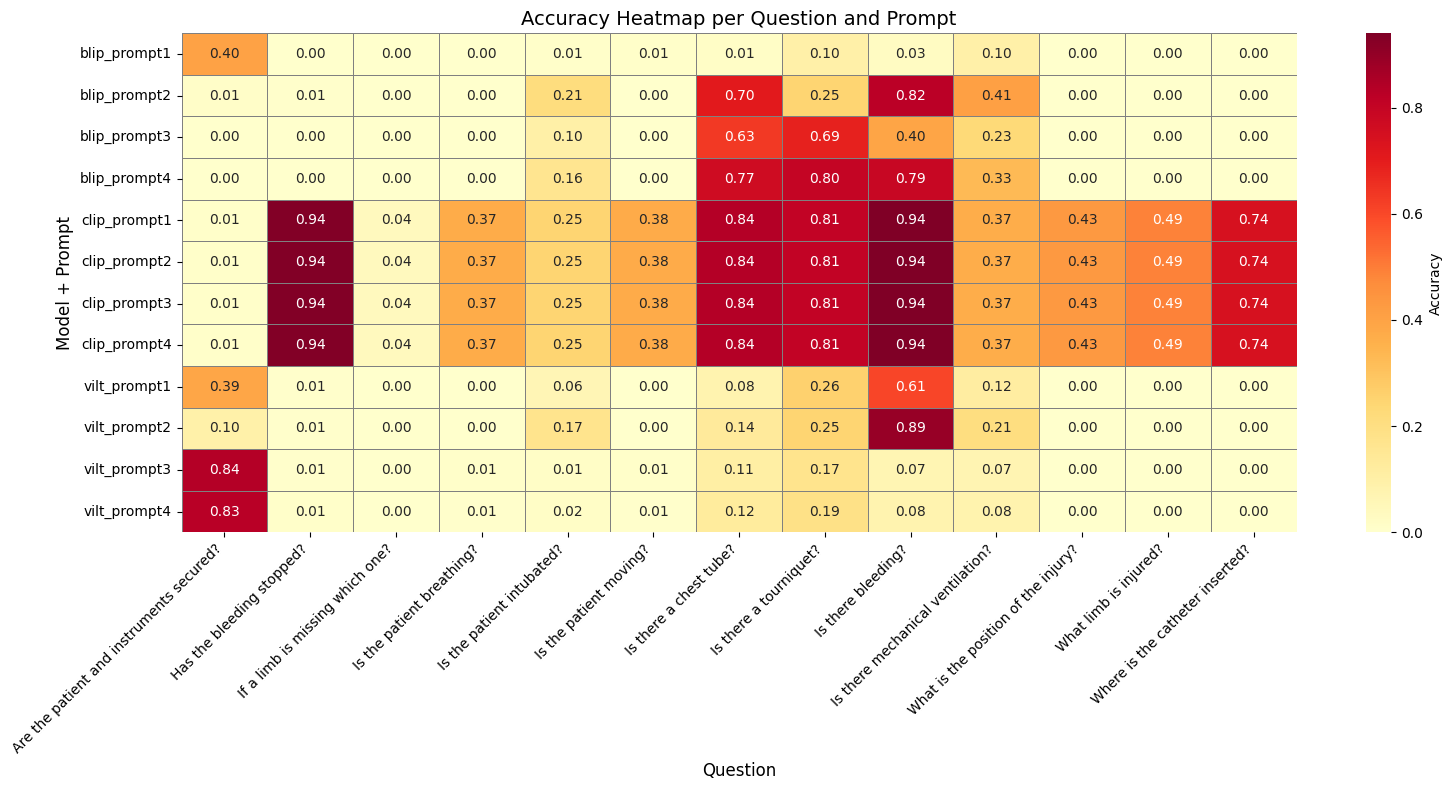

In [74]:
plot_accuracy_heatmap(all_metrics_df)